## Dependencias

In [119]:
import numpy as np
import pandas as pd

import datetime as datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from varclushi import VarClusHi

from functools import reduce
cf.go_offline()
pd.set_option('display.max_columns', None)

## Lectura de datos

In [120]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Regresión_Lineal/insurance.csv'

In [121]:
df = pd.read_csv(ruta)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [122]:
df.shape

(1338, 7)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [124]:
# Hombre = 1
# Mujer = 0

for v in list(df['sex'].unique()):
    if v == 'female':
        df.loc[df['sex'] == v, 'sex'] = 0
    if v == 'male':
        df.loc[df['sex'] == v, 'sex'] = 1
        
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [125]:
df['sex'] = pd.to_numeric(df['sex'])

In [126]:
# no = 0
# yes = 1

for v in list(df['smoker'].unique()):
    if v == 'no':
        df.loc[df['smoker'] == v, 'smoker'] = 0
    if v == 'yes':
        df.loc[df['smoker'] == v, 'smoker'] = 1
        
df['smoker'] = pd.to_numeric(df['smoker'])
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [127]:
for v in list(df['region'].unique()):
    if v == 'southeast':
        df.loc[df['region'] == v, 'region'] = 1
    if v == 'southwest':
        df.loc[df['region'] == v, 'region'] = 2
    if v == 'northwest':
        df.loc[df['region'] == v, 'region'] = 3
    if v == 'northeast':
        df.loc[df['region'] == v, 'region'] = 4
        
df['region'] = pd.to_numeric(df['region'])
df.head() 

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,2,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,3,21984.47061
4,32,1,28.880,0,0,3,3866.85520


In [128]:
df.insert(0,'id',df.index)

## Definición de variables

In [129]:
um = ['id']
vart = ['charges']
varc = [v for v in df.columns if v not in vart and v not in um]

In [130]:
X = df.copy()

## Análisis exploratorio

### Valores nulos

In [131]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.0
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
charges,0.0


### Multicolinealidad

In [132]:
'''vc = VarClusHi(df=X[varc], feat_list= varc).varclus().rsquare.sort_values(by = ['Cluster', 'RS_Ratio']).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best '''

"vc = VarClusHi(df=X[varc], feat_list= varc).varclus().rsquare.sort_values(by = ['Cluster', 'RS_Ratio']).reset_index(drop=True)\ndisplay(vc)\nbest = sorted(vc.groupby('Cluster').first()['Variable'])\nbest "

### Extremos

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'region'}>]], dtype=object)

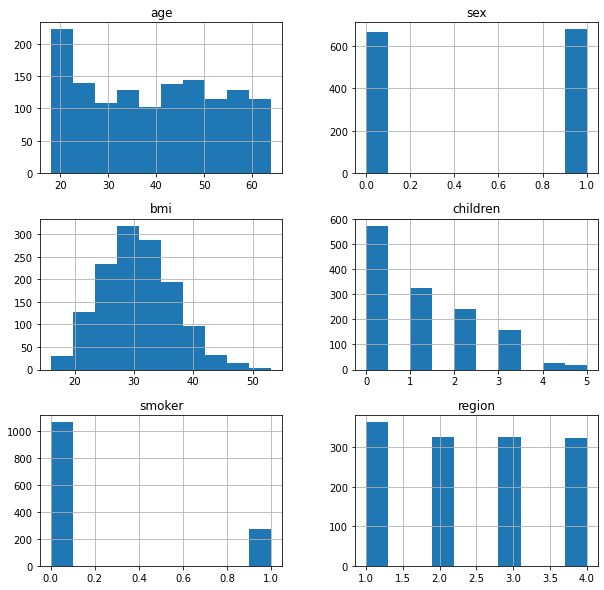

In [133]:
X[varc].hist(figsize = (10,10))

In [134]:
for v,li,ls in X[varc].describe(percentiles = [0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like = 'ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.979073
1    0.020927
Name: ex_, dtype: float64

In [135]:
df[um] = X[um]
df[vart] = X[vart]

In [136]:
X = X.loc[X['ex_'] == 0].drop(X.filter(like='ex_').columns, axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'region'}>]], dtype=object)

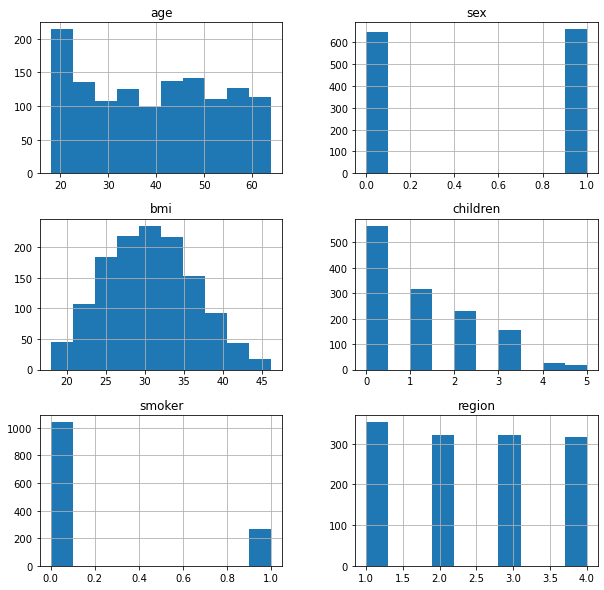

In [137]:
X[varc].hist(figsize = (10,10))

### Selección de variables con mayor poder predictivo

In [138]:
'''sk = SelectKBest(k = len(best), score_func= f_regression)
sk.fit(X[best], X[vart[0]]) '''

'sk = SelectKBest(k = len(best), score_func= f_regression)\nsk.fit(X[best], X[vart[0]]) '

In [139]:
'''pd.DataFrame(zip(best,sk.scores_), 
                 columns = ['var', 'score']).set_index('var').sort_values(by = 'score',
                                                                         ascending = False).iplot(kind = 'bar',
                                                                                                 color = 'orange')
                                                                                                 '''

"pd.DataFrame(zip(best,sk.scores_), \n                 columns = ['var', 'score']).set_index('var').sort_values(by = 'score',\n                                                                         ascending = False).iplot(kind = 'bar',\n                                                                                                 color = 'orange')\n                                                                                                 "

In [140]:
# best = [a for a,b in zip(best, sk.get_support()) if b]

In [141]:
# best

## Partición

In [142]:
Xt,Xv,yt,yv = train_test_split(X[um+varc], X[um+vart], train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [143]:
modelo = LinearRegression(n_jobs=-1)

In [144]:
modelo.fit(Xt[varc],yt[vart[0]])

LinearRegression(n_jobs=-1)

In [145]:
modelo.coef_, modelo.intercept_

(array([  256.9867243 ,   -54.81076523,   365.90122763,   451.12597347,
        23895.31913568,   416.11471885]),
 -14364.277215229793)

## Validación del modelo

In [146]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [147]:
St['y^'] = modelo.predict(Xt[varc])
Sv['y^'] = modelo.predict(Xv[varc])

In [148]:
print(mean_absolute_error(y_pred= St['y^'], y_true = St[vart[0]]))
print(mean_absolute_error(y_pred= Sv['y^'], y_true = Sv[vart[0]]))

4176.11777464577
4145.364918392736


<AxesSubplot:ylabel='Density'>

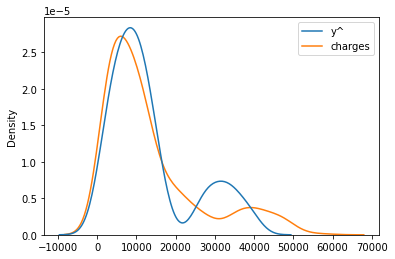

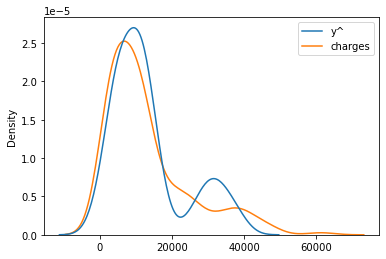

In [149]:
plt.figure()
sns.kdeplot(data = St[['y^']+vart])
plt.figure()
sns.kdeplot(data = Sv[['y^']+vart])

In [150]:
St.head()

,id,age,sex,bmi,children,smoker,region,charges,y^
0,269,49,1,25.84,1,0,4,9282.4806,9743.734081
1,70,27,0,24.75,0,1,1,16577.7795,25941.853579
2,120,44,1,37.10,2,0,2,7740.3370,12197.744819
3,1313,19,0,34.70,2,1,2,36397.5760,28845.043666
4,682,39,1,35.30,2,1,2,40103.8900,34149.508123
